# Audio LSTM

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

In [3]:
from exp.nb_AudioCommon import *
from exp.nb_DataAugmentation import *

In [4]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

In [5]:
data_folder = datapath4file('sine')

In [6]:
data_folder = datapath4file('timit')

In [7]:
data_folder.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/timit/f0004_us_f0004_00446.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/m0002_us_m0002_00128.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/f0003_us_f0003_00279.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/f0001_us_f0001_00168.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/f0005_us_f0005_00286.wav')]

In [8]:
import glob

## Split Items

In [9]:
wavs = glob.glob(str(data_folder/'**/*.wav'), recursive=True)
twenty_percent = int(len(wavs) * 0.2)

In [10]:
wavs = wavs[:200]

In [11]:
sig, sr = torchaudio.load(str(wavs[0]))

In [12]:
from sklearn import model_selection

In [13]:
train, valid = model_selection.train_test_split(wavs, test_size=0.2, random_state=42)

In [14]:
len(train), len(valid)

(160, 40)

## Label Items

Should we use stft?

In [15]:
def trim_start(spectro, min_spectro=-79.9):
    for col in range(0, spectro.shape[2]):
        m = spectro[:,:,col].mean()
        if m > min_spectro:
            return spectro[:,:,col:]

In [16]:
def trim_end(spectro, min_spectro=-79.9):
    for i in range(1, spectro.shape[2]):
        col = spectro.shape[2] - i
        m = spectro[:,:,col].mean()
        if m > min_spectro:
            return spectro[:,:,:col]

In [17]:
def file_to_spectro(p):
    aud = AudioData.load(p)
    img = tfm_spectro(aud, n_mels=128, ws=300, n_fft=1024, to_db_scale=True)
    img = trim_start(img)
    img = trim_end(img)
    return img

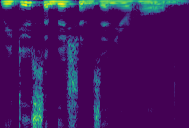

torch.Size([1, 128, 189])

tensor([[[-80.0000, -50.7048, -36.0475,  ..., -48.3427, -55.4040, -63.3225],
         [-68.2511, -33.3100, -21.5637,  ..., -46.8422, -54.3731, -57.9823],
         [-71.1004, -32.5706, -27.3979,  ..., -57.8907, -61.3387, -63.0678],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000]]])


In [18]:
def test_file_to_spectro():
    img = file_to_spectro(wavs[1])
    display(Image(img),img.shape)
    print(img[:10])
test_file_to_spectro()

In [19]:
data_item = file_to_spectro(wavs[1])

In [20]:
default_pad = torch.zeros(1, data_item.shape[1], 1) # MUST BE COLUMN shape(1, n_mels, 1)

In [21]:
global_seq_len = 50

In [22]:
def chunkify(spectro, col, seq_len):
    start = col
    end = col + seq_len
    chunk = spectro[:,:,start:end]
    chunk_len = chunk.shape[2]
    if chunk_len < seq_len:
        num_cols_to_pad = seq_len - chunk_len
        # repeat padded column w: (num_channels, how many times to stack column in y dir, number of columns to add)
        padded = default_pad.clone().repeat(spectro.shape[0], 1, num_cols_to_pad)
        chunk = torch.cat((chunk, padded), 2)
    chunk = chunk.squeeze(0) # remove channel
    return chunk

In [23]:
def test_chunkify():
    max_len = data_item.shape[1]
    c = chunkify(data_item, 0, seq_len=10); assert 10 == c.shape[1]
    c = chunkify(data_item, 5, seq_len=10); assert 10 == c.shape[1]
    c = chunkify(data_item, max_len - 50, seq_len=10)
    c = chunkify(data_item, max_len - 5, seq_len=10)
    print('PASSED')
    
test_chunkify()

PASSED


In [24]:
def sequencify_and_label(spectro, seq_len, default_pad=default_pad):
    max_non_pad_len = seq_len//2
    ret = []
    for col in range(0, spectro.shape[2] - max_non_pad_len):
        x = chunkify(spectro, col, seq_len=seq_len)
        y = chunkify(spectro, col + 1, seq_len=seq_len)
        ret.append((x, y))
    return ret

In [25]:
def test_sequencify_and_label(col, seq_len):
    list_x_and_y = sequencify_and_label(data_item, seq_len)
    print(len(list_x_and_y))
    tup_x_and_y = list_x_and_y[col]
    display(Image(tup_x_and_y[0].unsqueeze(0)))
    display(Image(tup_x_and_y[1].unsqueeze(0)))
test_sequencify_and_label(0, 10)
test_sequencify_and_label(data_item.shape[2] - 8, 10)

184


184


In [26]:
def flatten(list_of_lists):
    return [y for x in list_of_lists for y in x]

In [27]:
def files_to_x_y_seq(file_list, seq_len, default_pad=default_pad):
    processed = []
    for file in file_list:
        spectro = file_to_spectro(file)
        seqs = sequencify_and_label(spectro, seq_len=seq_len, default_pad=default_pad)
        processed.append(seqs)
    return flatten(processed)

In [28]:
def test_files_to_x_y_seq():
    res = files_to_x_y_seq(train[:10], 10)
    print(len(res))
    assert isinstance(res, list)
    assert isinstance(res[0], tuple)
    assert res[0][0].shape == res[0][1].shape
    print(res[0][0].shape)
test_files_to_x_y_seq()

2586
torch.Size([128, 10])


In [29]:
%%time
train_ds = files_to_x_y_seq(train, seq_len=global_seq_len)
valid_ds = files_to_x_y_seq(valid, seq_len=global_seq_len)

CPU times: user 9.91 s, sys: 392 ms, total: 10.3 s
Wall time: 2.57 s


In [30]:
bs = 64

In [31]:
train_dl, valid_dl = DataLoader(train_ds, batch_size=bs), DataLoader(valid_ds, batch_size=bs)

In [32]:
def permute_collate(batch):
    ret = torch.utils.data.dataloader.default_collate(batch)
    ret[0] = ret[0].permute((2, 0, 1)).contiguous()
    ret[1] = ret[1].permute((2, 0, 1)).contiguous()
    return ret

In [33]:
db = DataBunch(train_dl, valid_dl, collate_fn=permute_collate)

In [34]:
def test_batch():
    batch = db.one_batch()
    assert isinstance(batch, tuple)
    xb = batch[0]
    yb = batch[1]
    assert isinstance(xb, torch.Tensor)
    assert isinstance(yb, torch.Tensor)
    assert xb.shape == yb.shape
    print(xb.shape, yb.shape)
    print('PASSED')
test_batch()

torch.Size([50, 64, 128]) torch.Size([50, 64, 128])
PASSED


## Model

In [35]:
class SimpleLSTM(nn.Module):
    def __init__(self,
                 input_size=128,
                 hidden_size=128,
                 max_seq_len=50):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
        ])
        
    def forward(self, *tup_batch):
        outputs = []
        hiddens = []
        seq_batch = tup_batch[0]
        hidden = None
        for i in range(0, seq_batch.shape[0]):
            sequence = seq_batch[i,:,:].unsqueeze(0)
            hidden = None
            out = None
            for rnn in self.rnns:
                out, hidden = rnn(sequence, hidden)
            outputs.append(out)
            hiddens.append(hidden)
        ret = torch.stack(outputs, dim=0)
        return ret.squeeze(1)

In [40]:
def custom_loss(predicted, expected):
    cs = torch.nn.functional.cosine_similarity(predicted, expected, dim=2)
    sq = cs * cs # element-wise product
    summed = sq.sum()
    return summed

In [41]:
lstm = SimpleLSTM(max_seq_len=global_seq_len); lstm.cuda()
learn = Learner(db, lstm, loss_func=custom_loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


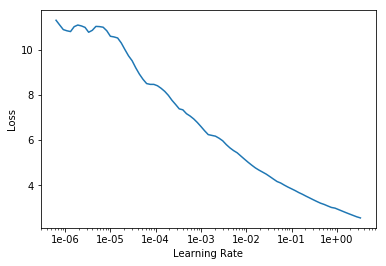

In [42]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-04)

epoch,train_loss,valid_loss,time
0,0.400541,0.377025,00:59
1,0.205352,0.221415,00:59
2,0.167314,0.199017,00:59
